### Classification with Pycaret

- Pycaret install
- install on Anaconda Propmt
1. conda create -n pycaret python=3.8
2. conda activate pycaret
3. pip install pycaret
4. pip install jupyter notebook

- Use on Anaconda Propmt
1. conda activate pycaret
2. jupyter notebook 

### 0. Problem Statement and Dataset

- The problem is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.   
- The data has been split into two groups:
  - training set (train.csv) should be used to build your machine learning models. 
  - test set (test.csv) should be used to see how well your model performs on unseen data.  

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('./data/titanic_train.csv') # for training
test = pd.read_csv('./data/titanic_test.csv') # for submission
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Name,Ticket,Cabin,Embarked
0,1,0,3,1,22.0,1,0,7.2500,"Braund, Mr. Owen Harris",A/5 21171,NaN,S
1,2,1,1,0,38.0,1,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85,C
2,3,1,3,0,26.0,0,0,7.9250,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN,S
3,4,1,1,0,35.0,1,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123,S
4,5,0,3,1,35.0,0,0,8.0500,"Allen, Mr. William Henry",373450,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,13.0000,"Montvila, Rev. Juozas",211536,NaN,S
887,888,1,1,0,19.0,0,0,30.0000,"Graham, Miss. Margaret Edith",112053,B42,S
888,889,0,3,0,NaN,1,2,23.4500,"Johnston, Miss. Catherine Helen ""Carrie""",W./C. 6607,NaN,S
889,890,1,1,1,26.0,0,0,30.0000,"Behr, Mr. Karl Howell",111369,C148,C


### 2. Set up Environment (Data Preprocessing & Feature Engineering)
*This step initializes the training environment and performs the data preprocessing & feature engineering.*

In [2]:
from pycaret.classification import *

exp01 = setup(
    train, target='Survived', session_id=123,
    ignore_features=['PassengerId','Name', 'Ticket', 'Cabin'], numeric_features=['Pclass', 'SibSp', 'Parch'], 
    normalize=True,
    ignore_low_variance=True,
    remove_multicollinearity=True,
    fold_shuffle=True
)

,Description,Value
0,session_id,123
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(891, 12)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


### 3. Compare Models
*This step trains and evaluates performance of all estimators available in the model library using cross validation.*

In [3]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [4]:
# 특정모델 생성 ex) dt = create_model('dt')
clfs = compare_models(n_select=5, exclude=['svm', 'ridge', 'lda', 'gbc'], sort='AUC', fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8042,0.8644,0.6968,0.7867,0.7366,0.5818,0.5869,0.0120
rf,Random Forest Classifier,0.7978,0.8588,0.7132,0.7608,0.7340,0.5715,0.5743,0.0600
lr,Logistic Regression,0.7962,0.8556,0.7217,0.7540,0.7348,0.5698,0.5730,1.0700
knn,K Neighbors Classifier,0.7898,0.8387,0.7216,0.7368,0.7269,0.5565,0.5587,0.5820
ada,Ada Boost Classifier,0.8026,0.8382,0.7421,0.7563,0.7466,0.5852,0.5879,0.0200
et,Extra Trees Classifier,0.7930,0.8264,0.6969,0.7594,0.7248,0.5596,0.5627,0.0500
nb,Naive Bayes,0.6405,0.8174,0.1069,0.8433,0.1859,0.1074,0.2041,0.5840
dt,Decision Tree Classifier,0.7576,0.7494,0.7007,0.6886,0.6934,0.4932,0.4944,0.4740
dummy,Dummy Classifier,0.6083,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0040
qda,Quadratic Discriminant Analysis,0.6083,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0040


### 4. Tune Models
*This step tunes the hyperparameters of a given estimator.*

In [5]:
# 특정모델 튜닝 ex) tuned_dt = tune_model(dt, search_library = 'optuna')
tuned_models = [tune_model(m, optimize='AUC', n_iter=30, fold=5) for m in clfs]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7520,0.8328,0.6122,0.7143,0.6593,0.4662,0.4696
1,0.7760,0.8358,0.6939,0.7234,0.7083,0.5266,0.5269
2,0.8160,0.8652,0.6531,0.8421,0.7356,0.5980,0.6093
3,0.8306,0.8660,0.7347,0.8182,0.7742,0.6393,0.6417
4,0.8065,0.8882,0.8333,0.7143,0.7692,0.6043,0.6096
Mean,0.7962,0.8576,0.7054,0.7625,0.7293,0.5669,0.5714
Std,0.0284,0.0207,0.0759,0.0559,0.0424,0.0622,0.0635


### 5. Ensemble Models

In [6]:
# Averaging
blender = blend_models(estimator_list=tuned_models, method='soft', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7920,0.8559,0.7143,0.7447,0.7292,0.5605,0.5608
1,0.8000,0.8433,0.6939,0.7727,0.7312,0.5727,0.5748
2,0.8080,0.8667,0.6327,0.8378,0.7209,0.5789,0.5922
3,0.8548,0.8906,0.7143,0.8974,0.7955,0.6852,0.6959
4,0.8306,0.9010,0.8125,0.7647,0.7879,0.6472,0.6480
Mean,0.8171,0.8715,0.7135,0.8035,0.7529,0.6089,0.6143
Std,0.0229,0.0214,0.0578,0.0564,0.0319,0.0487,0.0504


In [7]:
# Stacking
stacker = stack_models(estimator_list=tuned_models, meta_model=create_model('lr'), fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.8484,0.7347,0.7500,0.7423,0.5789,0.5790
1,0.8000,0.8441,0.7143,0.7609,0.7368,0.5758,0.5766
2,0.8240,0.8677,0.6735,0.8462,0.7500,0.6169,0.6265
3,0.8710,0.8963,0.8163,0.8511,0.8333,0.7281,0.7286
4,0.8306,0.8978,0.8125,0.7647,0.7879,0.6472,0.6480
Mean,0.8251,0.8709,0.7503,0.7946,0.7701,0.6294,0.6317
Std,0.0261,0.0228,0.0560,0.0444,0.0363,0.0559,0.0557


### 6. Select Model
*This step returns the best model out of all trained models in current session.*

In [8]:
best_model = automl(optimize='AUC')
best_model

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                       criterion='gini', max_depth=9, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=220,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

### 7. Evaluate Model

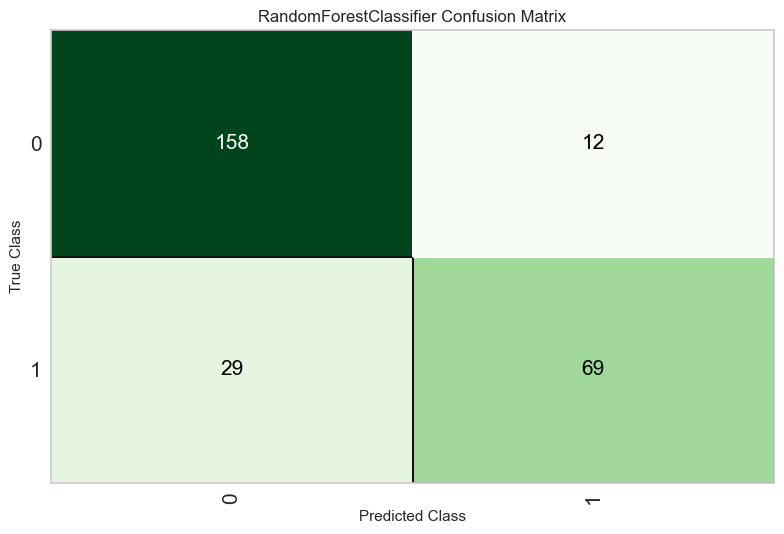

In [9]:
plot_model(best_model, plot='confusion_matrix')

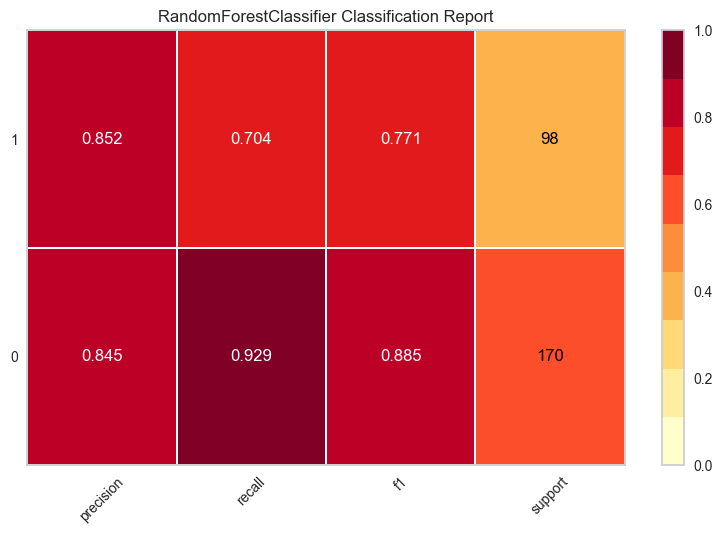

In [10]:
plot_model(best_model, plot='class_report')

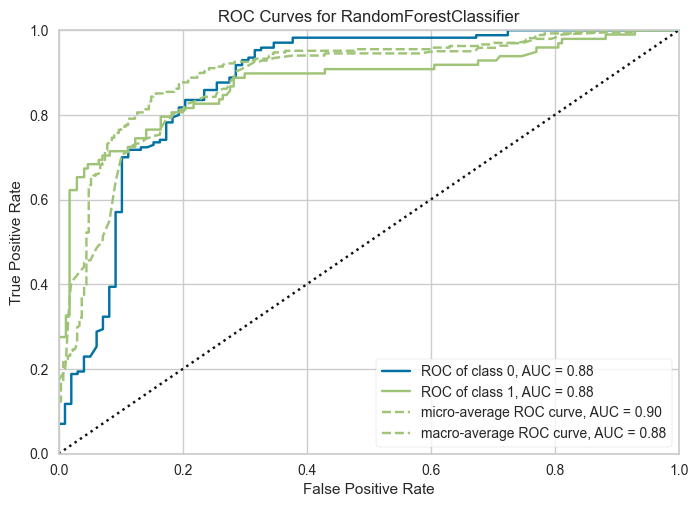

In [11]:
plot_model(best_model, plot='auc')
#evaluate_model(best_model)

### 8. Deploy Model

In [12]:
# make predictions (class label & probability)
pred = predict_model(best_model, data=test)
pred

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8683,0.9303,0.7353,0.9009,0.8097,0.7106,0.7192


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Name,Ticket,Cabin,Embarked,Label,Score
0,496,0,3,1,NaN,0,0,14.4583,"Yousseff, Mr. Gerious",2627,NaN,C,0,0.8200
1,649,0,3,1,NaN,0,0,7.5500,"Willey, Mr. Edward",S.O./P.P. 751,NaN,S,0,0.9341
2,279,0,3,1,7.0,4,1,29.1250,"Rice, Master. Eric",382652,NaN,Q,0,0.8235
3,32,1,1,0,NaN,1,0,146.5208,"Spencer, Mrs. William Augustus (Marie Eugenie)",PC 17569,B78,C,1,0.9717
4,256,1,3,0,29.0,0,2,15.2458,"Touma, Mrs. Darwis (Hanne Youssef Razi)",2650,NaN,C,1,0.6036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,364,0,3,1,35.0,0,0,7.0500,"Asim, Mr. Adola",SOTON/O.Q. 3101310,NaN,S,0,0.9533
353,407,0,3,1,51.0,0,0,7.7500,"Widegren, Mr. Carl/Charles Peter",347064,NaN,S,0,0.9380
354,867,1,2,0,27.0,1,0,13.8583,"Duran y More, Miss. Asuncion",SC/PARIS 2149,NaN,C,1,0.8474
355,882,0,3,1,33.0,0,0,7.8958,"Markun, Mr. Johann",349257,NaN,S,0,0.9226


In [14]:
# make submission file, model
pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred.Score}).to_csv('titanic_submission.csv', index=False)
save_model(best_model, model_name = 'titanic_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['PassengerId', 'Name',
                                                        'Ticket', 'Cabin'],
                                       id_columns=['PassengerId'],
                                       ml_usecase='classification',
                                       numerical_features=['Pclass', 'SibSp',
                                                           'Parch'],
                                       target='Survived', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_av...
                  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                         class_weight={}, criterion='gini',
                                         max_depth=9, max_features='

<font color="#CC3D3D"><p>
# Build the Data App with Streamlit

- !pip install streamlit

In [15]:
%%writefile titanic_app.py

from pycaret.classification import load_model, predict_model
import streamlit as st
import pandas as pd

model = load_model('titanic_model')

st.title('Titanic Survival Prediction App')
Age = st.sidebar.slider("Your Age", 1,75,30)
Fare = st.sidebar.slider("Fare in 1912 $ (See Info)",15,500,40)
SibSp = st.sidebar.selectbox("How many siblings or spouses are travelling with you?",[0,1,2,3,4,5,6,7,8])
Parch = st.sidebar.selectbox("How many parents or children are travelling with you?",[0,1,2,3,4,5,6,7,8])
Sex = st.sidebar.selectbox("Select your Gender",["male","female"])
Pclass = st.sidebar.selectbox("Which Class is your ticket from?", [1,2,3])
Embarked = st.sidebar.selectbox("Where did you board the Titanic?", ["Cherbourg","Queenstown","Southampton"])
Embarked = Embarked[0]

features = {"Age": Age,
            "Fare": Fare, 
            "SibSp": SibSp, 
            "Parch": Parch, 
            "Sex": Sex, 
            "Pclass": Pclass, 
            "Embarked":Embarked}
features_df  = pd.DataFrame([features])
st.table(features_df)  

if st.button('Predict'):    
    prediction = predict_model(model, features_df)['Label'][0]
    if prediction == 0:
        st.write('You will die !')
    else:
        st.write('you will survive !')

Writing titanic_app.py


In [16]:
!streamlit run titanic_app.py

^C
